**CONVOLUTION**

In [1]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sirikaranam","key":"caeb2be241cbf93965304304321d526d"}'}

In [2]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 99% 806M/812M [00:03<00:00, 265MB/s]
100% 812M/812M [00:03<00:00, 230MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [21]:
# import the keras network library
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Dropout, Rescaling, MaxPool2D

In [6]:
import os, shutil, pathlib

#assign the data to directories
original_directory = pathlib.Path("train")
new_base_directory = pathlib.Path("cats_vs_dogs_small_1")


def subset_main(subset_1, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_directory / subset_1 / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_directory / fname, dst=dir / fname)

#split the data to training, validation abd test datasets
subset_main("train", start_index=158, end_index=1158)
subset_main("validation", start_index=1159, end_index=1659)
subset_main("test", start_index=1660, end_index=2160)

Using image_dataset_from_directory to read images.

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory
#assign the data to datasets
train_data = image_dataset_from_directory(new_base_directory / "train",
                                          image_size=(180, 180),
                                          batch_size=32)
validation_data = image_dataset_from_directory(new_base_directory / "validation",
                                               image_size=(180, 180),
                                               batch_size=32)
test_data = image_dataset_from_directory(new_base_directory / "test",
                                         image_size=(180, 180),
                                         batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [8]:
import numpy as np
import tensorflow as tf
random_num = np.random.normal(size=(1000, 16))
data = tf.data.Dataset.from_tensor_slices(random_num)

In [9]:
for i, element in enumerate(data):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [10]:
batchdata = data.batch(32)
for i, element in enumerate(batchdata):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [11]:
reshapedata = data.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshapedata):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [12]:
for batchdata, labels_batch in train_data:  # Use train_dataset instead of train
    print("data batch shape:", batchdata.shape)
    print("labels batch shape:", labels_batch.shape)
    break  # This will print the first batch only and stop the loop

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Instantiating a small convnet for dogs vs. cats classification with dropout.

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

input = keras.Input(shape=(180, 180, 3))
a = layers.Rescaling(1./255)(input)
a = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.Flatten()(a)
a = layers.Dropout(0.5)(a)
output1 = layers.Dense(1, activation="sigmoid")(a)
model1 = keras.Model(inputs=input, outputs=output1)

In [14]:
model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

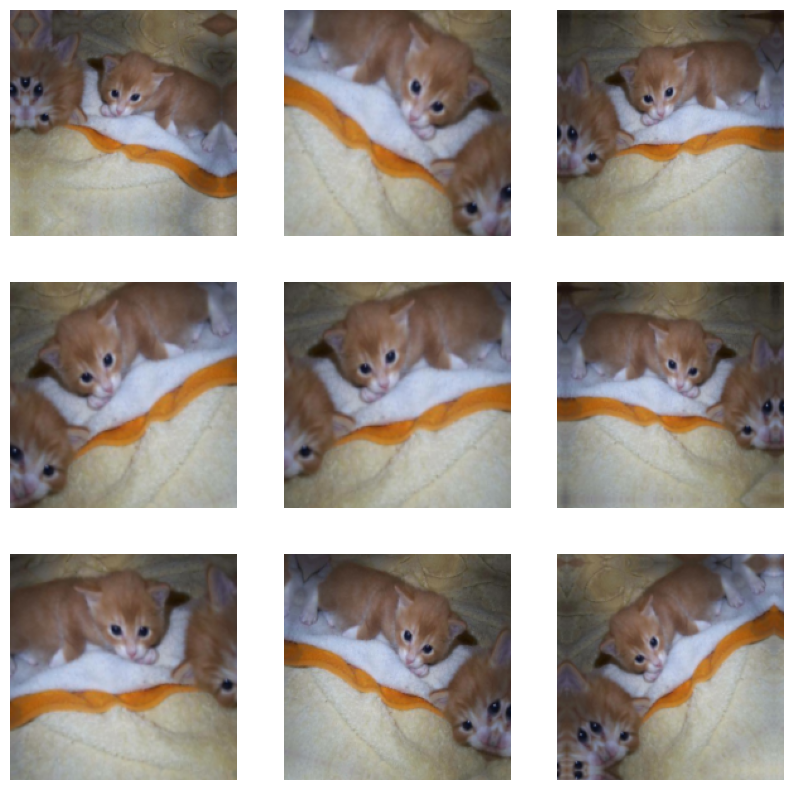

In [15]:
augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Fitting the model using a Dataset.

In [16]:
# import the keras network library
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping

callback1 = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
#fit the model
history1 = model1.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    callbacks=callback1)

Epoch 1/20
63/63 [==============================] - 19s 285ms/step - loss: 0.6938 - accuracy: 0.5240 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 17s 276ms/step - loss: 0.6887 - accuracy: 0.5260 - val_loss: 0.6764 - val_accuracy: 0.5450
Epoch 3/20
63/63 [==============================] - 17s 277ms/step - loss: 0.6701 - accuracy: 0.5885 - val_loss: 0.6405 - val_accuracy: 0.6190
Epoch 4/20
63/63 [==============================] - 17s 270ms/step - loss: 0.6409 - accuracy: 0.6265 - val_loss: 0.6073 - val_accuracy: 0.6750
Epoch 5/20
63/63 [==============================] - 17s 268ms/step - loss: 0.6106 - accuracy: 0.6650 - val_loss: 0.6417 - val_accuracy: 0.6270
Epoch 6/20
63/63 [==============================] - 17s 273ms/step - loss: 0.5856 - accuracy: 0.6830 - val_loss: 0.5934 - val_accuracy: 0.6700
Epoch 7/20
63/63 [==============================] - 17s 266ms/step - loss: 0.5738 - accuracy: 0.7060 - val_loss: 0.5831 - val_accuracy: 0.7070

Displaying curves of loss and accuracy during training.

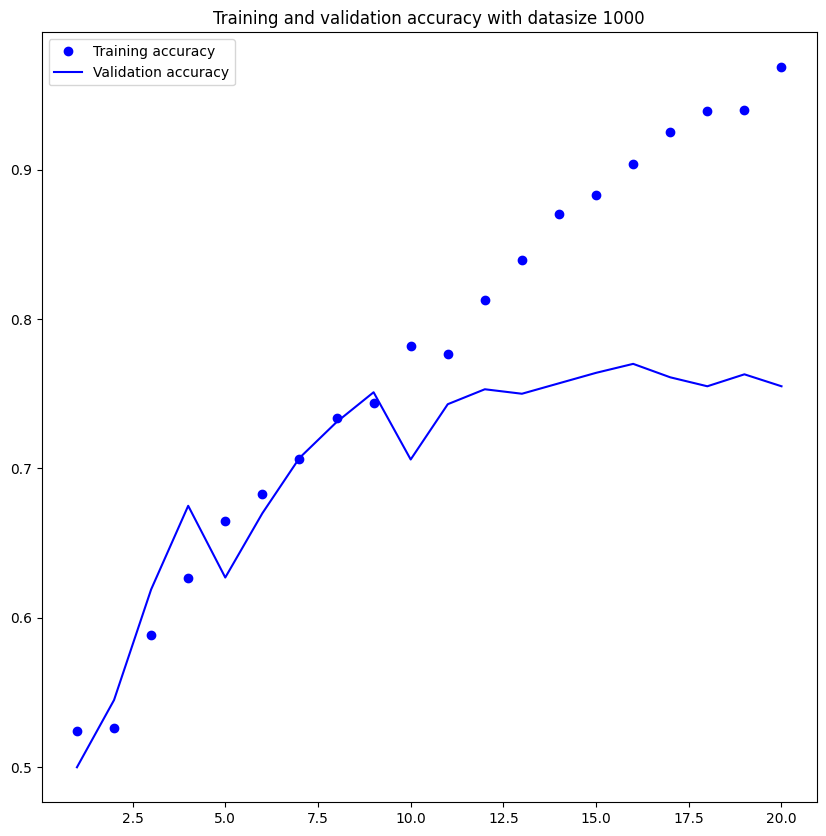

<Figure size 640x480 with 0 Axes>

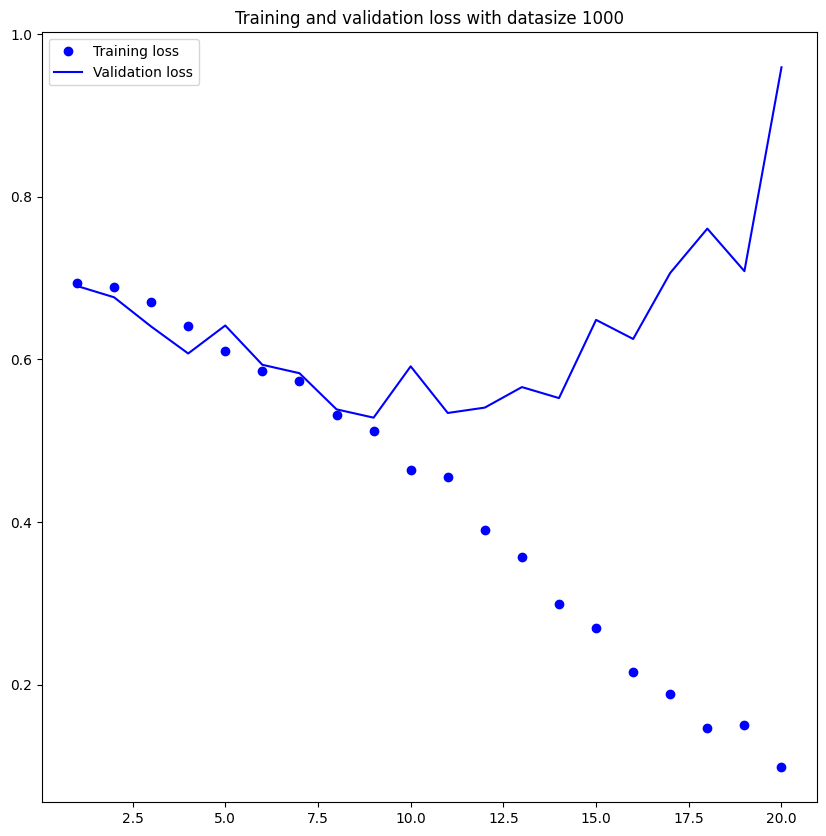

In [17]:
#import pyplot library
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
accuracy1 = history1.history["accuracy"]
val_accuracy1 = history1.history["val_accuracy"]
loss1 = history1.history["loss"]
val_loss1 = history1.history["val_loss"]
epochs = range(1, len(accuracy1) + 1)

#plot the traing and vlidation accuracies
plt.plot(epochs, accuracy1, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy1, "b", label="Validation accuracy")
plt.title("Training and validation accuracy with datasize 1000")
plt.legend()
plt.figure()

#plot the traing and vlidation losses
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss1, "bo", label="Training loss")
plt.plot(epochs, val_loss1, "b", label="Validation loss")
plt.title("Training and validation loss with datasize 1000")
plt.legend()
plt.show()


**2.Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**

Copying images to training, validation, and test directories with dataset size for training 1500.

In [24]:
#import the required libraries
import os, shutil, pathlib

#assign the data to directories
original_directory = pathlib.Path("train")
new_base_directory = pathlib.Path("cats_vs_dogs_small_2")

def subset_main(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_directory / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_directory / fname,
                            dst=dir / fname)

#split the data to training, validation abd test datasets
subset_main("train", start_index=158, end_index=1658)
subset_main("validation", start_index=1659, end_index=2159)
subset_main("test", start_index=2160, end_index=2660)



In [25]:
#Using image_dataset_from_directory to read images


from tensorflow.keras.utils import image_dataset_from_directory
#assign the data to datasets
train_data2 = image_dataset_from_directory(new_base_directory / "train", image_size=(180, 180),batch_size=32)
validation_data2 = image_dataset_from_directory(new_base_directory / "validation", image_size=(180, 180), batch_size=32)
test_data2 = image_dataset_from_directory(new_base_directory / "test", image_size=(180, 180), batch_size=32)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


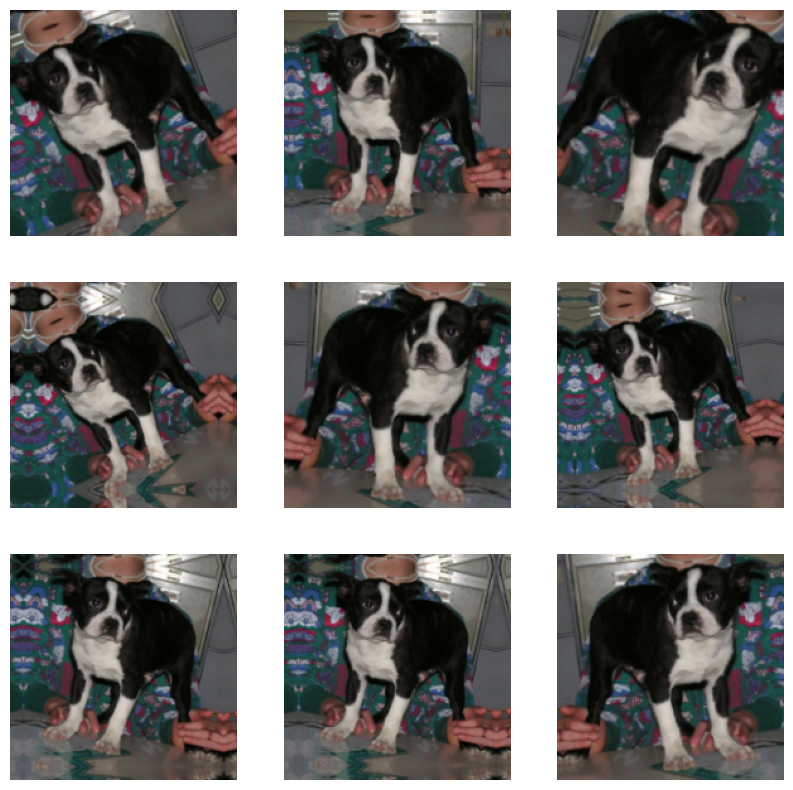

In [27]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more.
early_stopping_monitor = EarlyStopping(patience=10)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [30]:
inputs = keras.Input(shape=(180, 180, 3))
b = layers.Rescaling(1./255)(inputs)
b = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(b)
b = layers.MaxPooling2D(pool_size=2)(b)
b = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(b)
b = layers.MaxPooling2D(pool_size=2)(b)
b = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(b)
b = layers.MaxPooling2D(pool_size=2)(b)
b = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(b)
b = layers.MaxPooling2D(pool_size=2)(b)
b = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(b)
b = layers.Flatten()(b)
b = layers.Dropout(0.5)(b)
outputs = layers.Dense(1, activation="sigmoid")(b)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    callbacks=callbacks)

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                     

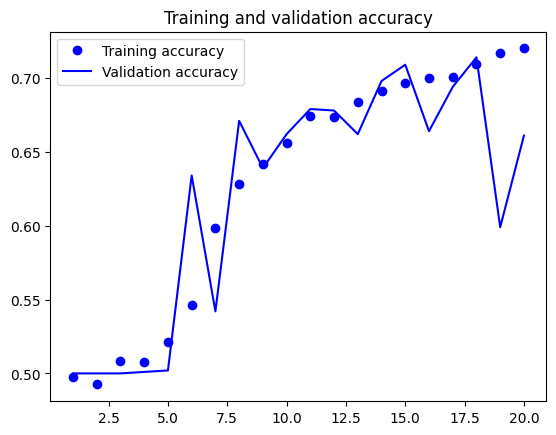

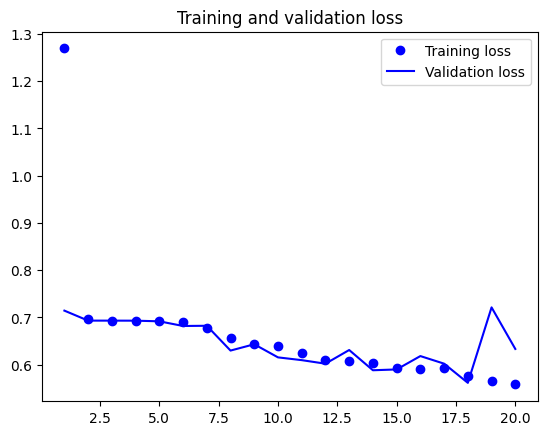

In [31]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**3.Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.**


Copying images to training, validation, and test directories with dataset size for training 2000.

In [32]:
#import the required libraries
import os, shutil, pathlib

#assign the data to directories
original_directory = pathlib.Path("train")
new_base_directory = pathlib.Path("cats_vs_dogs_small_3")

def subset_main(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_directory / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_directory / fname,
                            dst=dir / fname)

#split the data to training, validation abd test datasets
subset_main("train", start_index=158, end_index=2158)
subset_main("validation", start_index=2159, end_index=2659)
subset_main("test", start_index=2660, end_index=3160)

In [33]:
from tensorflow.keras.utils import image_dataset_from_directory

#assign the data to datasets
train_data3 = image_dataset_from_directory(new_base_directory / "train", image_size=(180, 180),batch_size=32)
validation_data3 = image_dataset_from_directory(new_base_directory / "validation", image_size=(180, 180), batch_size=32)
test_data3 = image_dataset_from_directory(new_base_directory / "test", image_size=(180, 180), batch_size=32)


Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                     

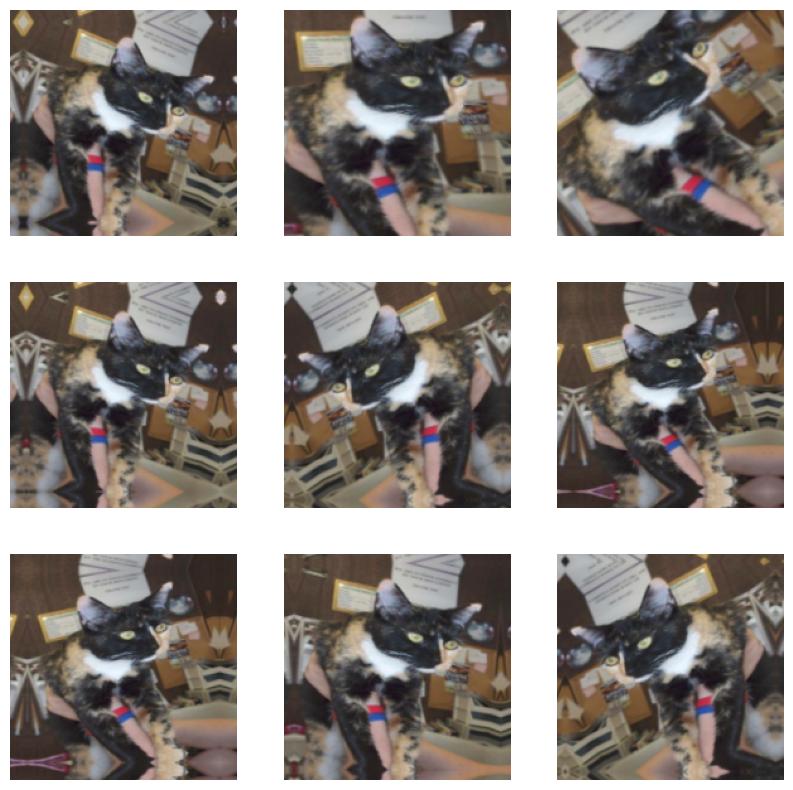

In [37]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more.
early_stopping_monitor = EarlyStopping(patience=10)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    callbacks=callbacks)




test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")


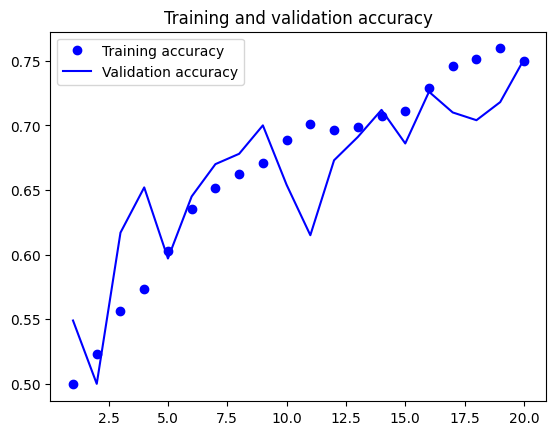

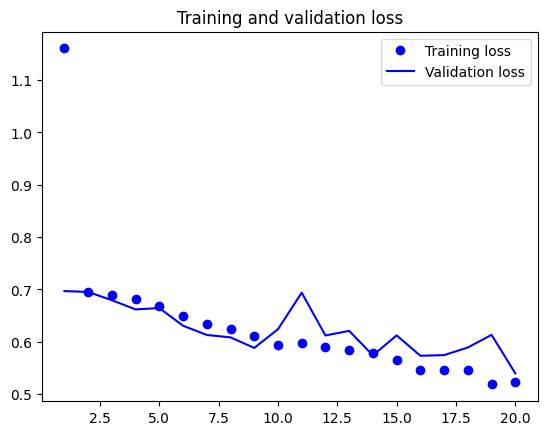

In [39]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.**


Pretrained Model 1 : Training sample of 2000, a validation sample of 1000, and a test sample of 1000.

VGG16 Pretrained Convnet Network

Using Feature Extraction with Data Augmentation and Fine-tuning

In [42]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)





58889256/58889256 [==============================] - 0s 0us/step


In [45]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_1 = keras.Model(inputs, outputs)
# Fine-tuning the model
model_pre_trained_1.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])


# Used early stopping to stop optimization
early_stopping_monitor = EarlyStopping(patience=10)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    callbacks=callbacks)


Epoch 1/20
63/63 [==============================] - 17s 266ms/step - loss: 0.4913 - accuracy: 0.7760 - val_loss: 0.5457 - val_accuracy: 0.7330
Epoch 2/20
63/63 [==============================] - 16s 261ms/step - loss: 0.4854 - accuracy: 0.7810 - val_loss: 0.6150 - val_accuracy: 0.7070
Epoch 3/20
63/63 [==============================] - 17s 264ms/step - loss: 0.4756 - accuracy: 0.7965 - val_loss: 0.5827 - val_accuracy: 0.7190
Epoch 4/20
63/63 [==============================] - 16s 262ms/step - loss: 0.4494 - accuracy: 0.7980 - val_loss: 0.5748 - val_accuracy: 0.7540
Epoch 5/20
63/63 [==============================] - 17s 266ms/step - loss: 0.4462 - accuracy: 0.8050 - val_loss: 0.6499 - val_accuracy: 0.7110
Epoch 6/20
63/63 [==============================] - 17s 263ms/step - loss: 0.4216 - accuracy: 0.8090 - val_loss: 0.6914 - val_accuracy: 0.6870
Epoch 7/20
63/63 [==============================] - 17s 262ms/step - loss: 0.4031 - accuracy: 0.8305 - val_loss: 0.5474 - val_accuracy: 0.7670

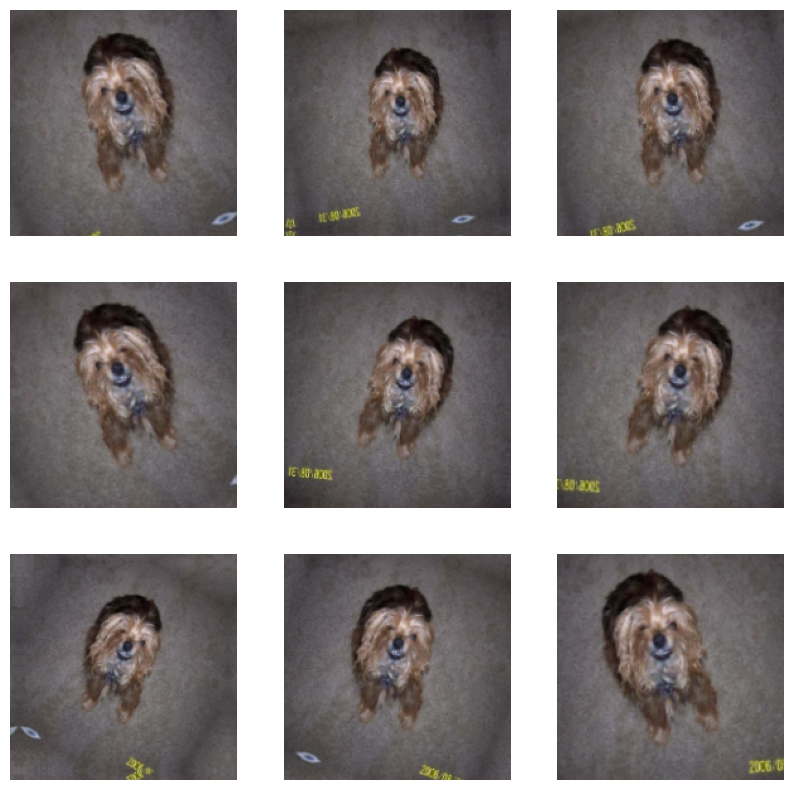

32/32 [==============================] - 2s 55ms/step - loss: 0.5463 - accuracy: 0.7550
Test accuracy: 0.755


In [47]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

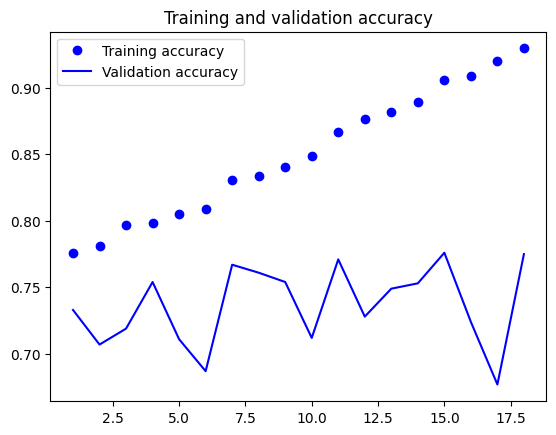

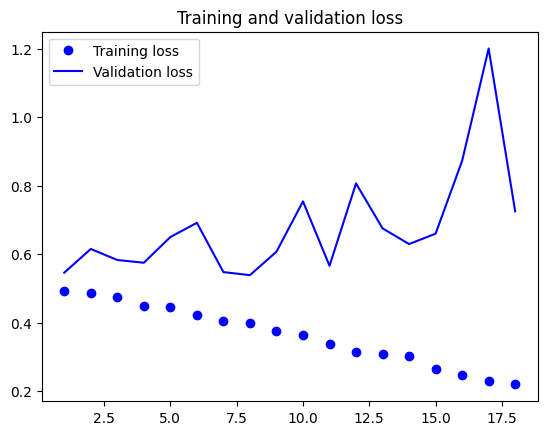

In [48]:
# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [50]:
import os
import shutil
import pathlib
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("validation", start_index=0, end_index=500)
make_subset("test", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=5000)

train_data = tf.keras.utils.image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_data = tf.keras.utils.image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_data = tf.keras.utils.image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_4000.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    callbacks=callbacks)


Found 9684 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Epoch 1/20
303/303 [==============================] - 77s 249ms/step - loss: 2.7651 - accuracy: 0.5448 - val_loss: 0.6697 - val_accuracy: 0.5680
Epoch 2/20
303/303 [==============================] - 77s 253ms/step - loss: 0.6788 - accuracy: 0.5729 - val_loss: 0.6857 - val_accuracy: 0.5720
Epoch 3/20
303/303 [==============================] - 76s 250ms/step - loss: 0.6702 - accuracy: 0.5847 - val_loss: 0.6659 - val_accuracy: 0.5770
Epoch 4/20
303/303 [==============================] - 75s 247ms/step - loss: 0.6717 - accuracy: 0.5697 - val_loss: 0.6580 - val_accuracy: 0.5850
Epoch 5/20
303/303 [==============================] - 74s 244ms/step - loss: 0.6563 - accuracy: 0.6066 - val_loss: 0.6547 - val_accuracy: 0.6115
Epoch 6/20
303/303 [==============================] - 74s 244ms/step - loss: 0.6373 - accuracy: 0.6189 - val_loss: 0.6244 - val_accuracy: 0.6505
Epoch 7

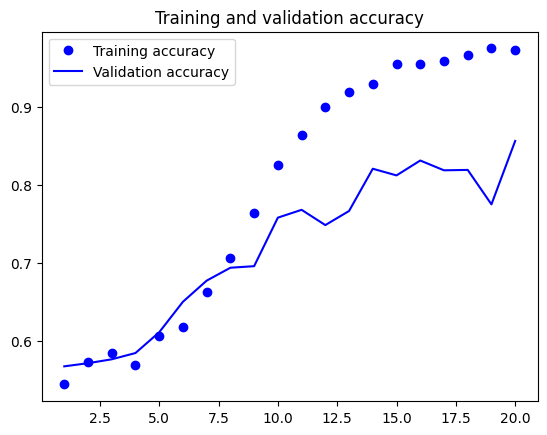

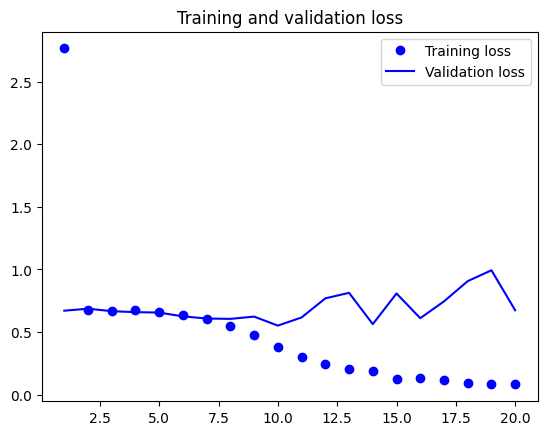

In [51]:
# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Epoch 1/20
303/303 [==============================] - 57s 179ms/step - loss: 0.8298 - accuracy: 0.5949 - val_loss: 0.4352 - val_accuracy: 0.7950
Epoch 2/20
303/303 [==============================] - 53s 175ms/step - loss: 0.5589 - accuracy: 0.7500 - val_loss: 0.2482 - val_accuracy: 0.9045
Epoch 3/20
303/303 [==============================] - 52s 171ms/step - loss: 0.4014 - accuracy: 0.8355 - val_loss: 0.1702 - val_accuracy: 0.9470
Epoch 4/20
303/303 [==============================] - 51s 168ms/step - loss: 0.3157 - accuracy: 0.8739 - val_loss: 0.1332 - val_accuracy: 0.9620
Epoch 5/20
303/303 [==============================] - 52s 171ms/step - loss: 0.2781 - accuracy: 0.8909 - val_loss: 0.1122 - val_accuracy: 0.9680
Epoch 6/20
303/303 [==============================] - 51s 169ms/step - loss: 0.2387 - accuracy: 0.9104 - val_loss: 0.0998 - val_accuracy: 0.9730
Epoch 7/20
303/303 [==============================] - 51s 168ms/step - loss: 0.2112 - accuracy: 0.9197 - val_loss: 0.0910 - val_ac

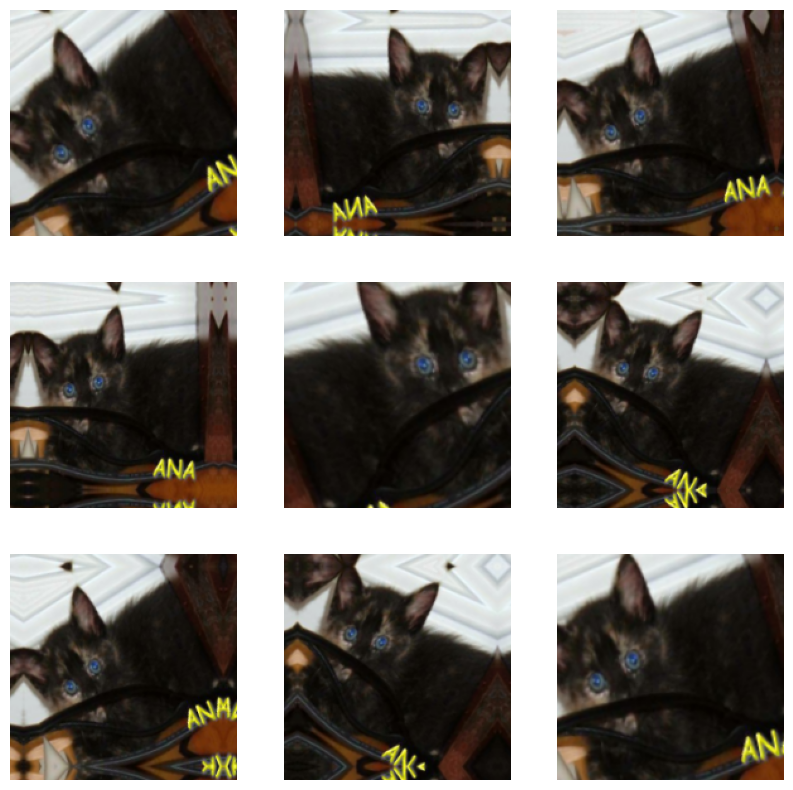

63/63 [==============================] - 9s 125ms/step - loss: 0.0568 - accuracy: 0.9800
Test accuracy: 0.980


In [53]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the MobileNetV2 convolutional base
conv_base  = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False)

# Freezing all layers until fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_2 = keras.Model(inputs, outputs)

# Fine-tuning the model
model_pre_trained_2.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

# Used early stopping to stop optimization
early_stopping_monitor = EarlyStopping(patience=10)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_2.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model_pre_trained_2.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    callbacks=callbacks)

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()


# Evaluate the model on the test set

test_model = keras.models.load_model("convnet_from_scratch_2.keras")
test_loss, test_acc = test_model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")


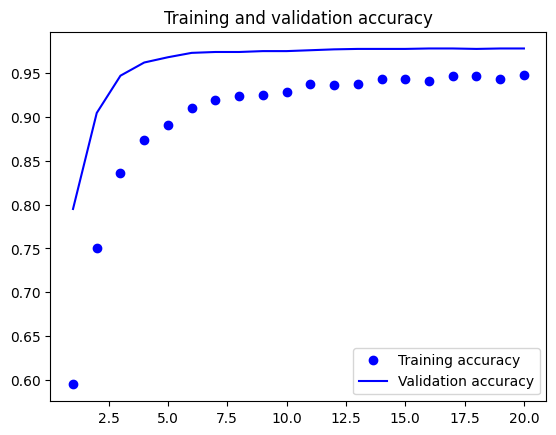

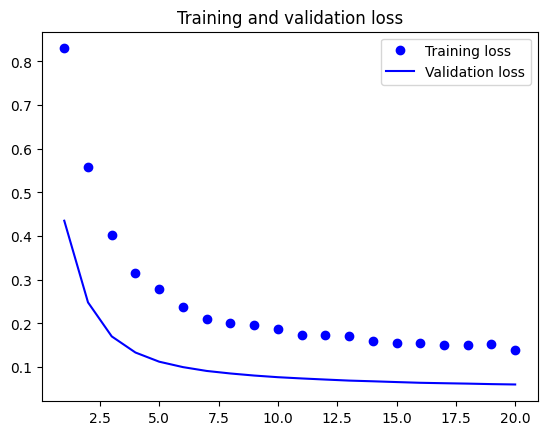

In [54]:
# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()